In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from pandas_profiling import ProfileReport
from scipy.stats import ttest_ind

from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import chi2, f_classif, SelectKBest, mutual_info_classif, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold

from sklearn.naive_bayes import GaussianNB
# from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tableone import TableOne

In [82]:
df = pd.read_csv("./Data/processed_panel_1and3.csv")

PROTEINS = df.iloc[:,1:df.columns.get_loc("Age")].columns.to_list()
CLINICAL = ['Age', 'Gender', 'Hypertension', 'Hyperchol',
       'Diabetes', 'Renal Insufficiency', 'Smoking Hx',
       #  'Dialysis', # Zero variance
       'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA',
       'statin', 'ACEi/ARB', 'B-bl', 'CCB', 'HCTZ, Lasix', 'Insulin',
       # 'oral hypoglyc' # correlated with Diabetes
       ]

TARGET = ["hasPAD"]
df.head()


,ID,IL-33,uPAR,CXCL6,ESM-1,SCF,TSG-14,IL-2,PCSK9,RAGE,...,Cornary artery disease,Stroke/TIA,statin,ACEi/ARB,B-bl,CCB,"HCTZ, Lasix",Insulin,oral hypoglyc,hasPAD
0,5,14.091162,557.896234,110.729424,1055.750683,116.074164,1333.413564,46.515919,69268.582453,3231.556933,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,0
1,14,33.331707,2383.453789,128.812424,472.920153,107.254642,570.205218,93.976533,66247.932316,2459.595380,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0
2,92,19.413896,922.174636,207.177434,983.060117,69.369572,1452.355327,59.580556,117311.334839,1455.813626,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,119,59.897453,2734.344683,645.989311,1323.804448,187.559274,1353.296620,134.539790,115404.072833,4621.795653,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0
4,124,37.126933,4847.796709,268.216338,991.308486,140.609145,1423.928314,113.068512,137419.409806,2821.843801,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0


# Intro

This file is created after the initial modeling and cleaning step "3_PAD_MODELING" was done on the PAD samples.

Here, I will go deeper in my approach to the exploratory data analysis and producing charts and plots about our predictors.

Also, the the modeling would be enhanced based on the feedbacks.

## Exploratory Analysis

In [97]:
pd.set_option('display.colheader_justify', 'right')
table1 = TableOne(df, columns=PROTEINS,groupby=["hasPAD"], pval=True, htest_name=True, dip_test=True, normal_test=True, tukey_test=True)
table1

Grouped by hasPAD                                                                                                   
                                                    Missing                 Overall                       0                       1 P-Value               Test
n                                                                               461                     166                     295                           
IL-33, mean (SD)                                          0             27.1 (22.6)             27.0 (31.7)             27.2 (15.3)   0.918  Two Sample T-test
uPAR, mean (SD)                                          15          1910.5 (959.5)          1713.4 (892.3)          2020.8 (979.5)   0.001  Two Sample T-test
CXCL6, mean (SD)                                          0           240.3 (184.3)           249.1 (216.2)           235.3 (163.9)   0.475  Two Sample T-test
ESM-1, mean (SD)                                          0           597.2 (290.2)           606.0 (310.2)           592.2 (278.8)   0.634  Two Sample T-test
SCF, mean (SD)                                           15            111.9 (49.0)            101.5 (39.8)            117.6 (52.6)  <0.001  Two Sample T-test
TSG-14, mean (SD)                                        14          1324.6 (636.0)          1214.6 (517.7)          1387.1 (687.3)   0.003  Two Sample T-test
IL-2, mean (SD)                                           0             70.9 (32.5)             67.1 (31.3)             73.0 (33.0)   0.056  Two Sample T-test
PCSK9, mean (SD)                                          0     167133.9 (478289.2)     149232.8 (251211.4)     177207.1 (567648.3)   0.466  Two Sample T-test
RAGE, mean (SD)                                           7         2461.3 (1462.5)          2236.9 (889.2)         2582.2 (1681.9)   0.004  Two Sample T-test
CD62P, mean (SD)                                          0       32637.7 (14142.5)       32668.8 (17245.5)       32620.2 (12084.3)   0.974  Two Sample T-test
ADAMTS13, mean (SD)                                      12    1077422.7 (501757.5)    1176294.7 (575232.6)    1021613.4 (446577.8)   0.003  Two Sample T-test
Tpo, mean (SD)                                            9          1544.8 (755.4)          1420.4 (474.8)          1612.9 (864.9)   0.002  Two Sample T-test
Tie-2, mean (SD)                                          0        16285.1 (8698.9)        16135.6 (8612.1)        16369.3 (8760.8)   0.781  Two Sample T-test
KIM-1, mean (SD)                                          0            100.4 (80.8)             98.3 (73.8)            101.7 (84.5)   0.653  Two Sample T-test
ICAM-1, mean (SD)                                         0     748798.6 (637652.1)     774678.4 (660349.0)     734235.7 (625186.5)   0.520  Two Sample T-test
Angiopoietin-1, mean (SD)                                 0       10734.4 (11430.8)       10451.6 (10960.0)       10893.5 (11702.7)   0.685  Two Sample T-test
TNF RII, mean (SD)                                       13         3119.0 (2191.3)         2626.5 (1289.1)         3387.4 (2513.8)  <0.001  Two Sample T-test
TNF RI, mean (SD)                                         0         1785.6 (1337.7)          1548.1 (979.4)         1919.2 (1487.2)   0.001  Two Sample T-test
BMP-2, mean (SD)                                          0             40.7 (18.6)             41.7 (13.7)             40.1 (20.9)   0.319  Two Sample T-test
ANGPTL3, mean (SD)                                        0       47866.8 (22404.5)       51946.4 (22308.3)       45571.2 (22167.6)   0.003  Two Sample T-test
ANGPTL4, mean (SD)                                        0      179933.6 (95839.2)      157511.8 (84055.1)      192550.7 (99812.5)  <0.001  Two Sample T-test
CD40 Ligand, mean (SD)                                    0         2240.1 (1867.6)         2168.9 (1765.9)         2280.1 (1924.2)   0.530  Two Sample T-test
CD40, mean (SD)                                           0        

In [95]:
df["PBEF/Visfatin"].describe()

count       444.000000
mean      24587.488754
std       57667.354364
min          83.187110
25%        5838.805264
50%       10283.498000
75%       17858.677023
max      548781.545206
Name: PBEF/Visfatin, dtype: float64

### Exploring the warning raised by Hartigan's Dip Test

In [55]:
df[["KIM-1", "BMP-2", "CXCL1", "PBEF/Visfatin"]].describe().round(2)

,KIM-1,BMP-2,CXCL1,PBEF/Visfatin
count,461.00,461.00,443.00,444.00
mean,100.45,40.65,237.50,24587.49
std,80.77,18.63,152.28,57667.35
min,16.99,6.19,4.09,83.19
25%,51.97,27.94,159.98,5838.81
50%,78.22,45.50,217.60,10283.50
75%,124.44,52.39,269.66,17858.68
max,855.40,259.94,2060.37,548781.55


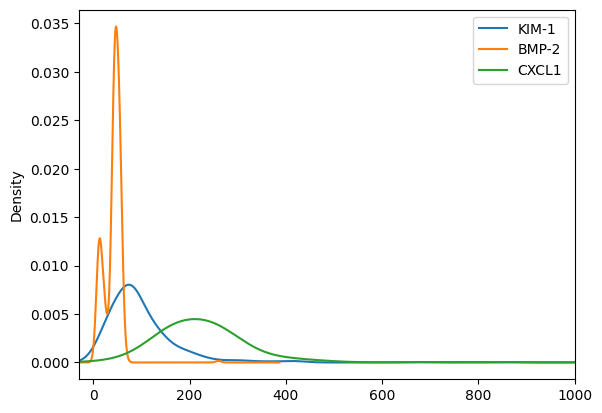

In [56]:
df[["KIM-1", "BMP-2", "CXCL1"]].dropna().plot.kde()
plt.xlim([-30, 1000])
plt.show()

> Protein BMP-2 appears to have a bimodal distribution

<AxesSubplot: ylabel='Density'>

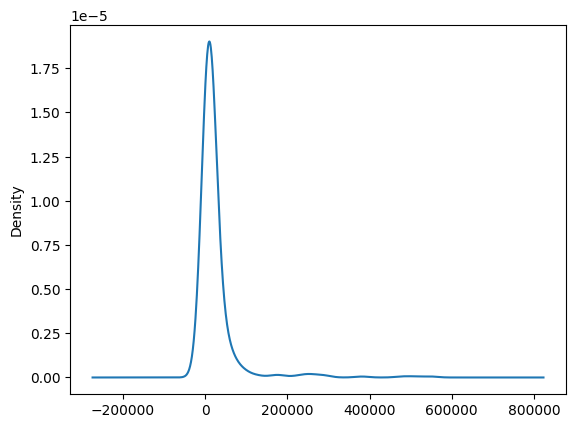

In [57]:
df["PBEF/Visfatin"].dropna().plot.kde()
## possibly outliers

In [58]:
### Trying on a smaller subset of proteins

In [59]:
## proteins with significant anova test from prev file

num_feat_selected = ['uPAR', 'SCF', 'TSG-14', 'RAGE', 'ADAMTS13', 'Tpo', 'TNF RII', 'TNF RI',
       'ANGPTL3', 'ANGPTL4', 'CD40', 'CXCL1', 'NT- pro BNP', 'Troponin I',
       'ANGPTL6', 'Alpha 1-Microglobulin', 'Galectin-9', 'PBEF/Visfatin',
       'Cathepsin S', 'APRIL/TNFSF13', 'Galectin-1', 'ALCAM/CD166', 'GDF-15',
       'Chemerin', 'Endostatin', 'Age']

table2 = TableOne(df, columns = num_feat_selected,  dip_test=True, normal_test=True, tukey_test=True)
table2

,,Missing,Overall
n,,,461
"uPAR, mean (SD)",,15,1910.5 (959.5)
"SCF, mean (SD)",,15,111.9 (49.0)
"TSG-14, mean (SD)",,14,1324.6 (636.0)
"RAGE, mean (SD)",,7,2461.3 (1462.5)
"ADAMTS13, mean (SD)",,12,1077422.7 (501757.5)
"Tpo, mean (SD)",,9,1544.8 (755.4)
"TNF RII, mean (SD)",,13,3119.0 (2191.3)
"TNF RI, mean (SD)",,0,1785.6 (1337.7)
"ANGPTL3, mean (SD)",,0,47866.8 (22404.5)


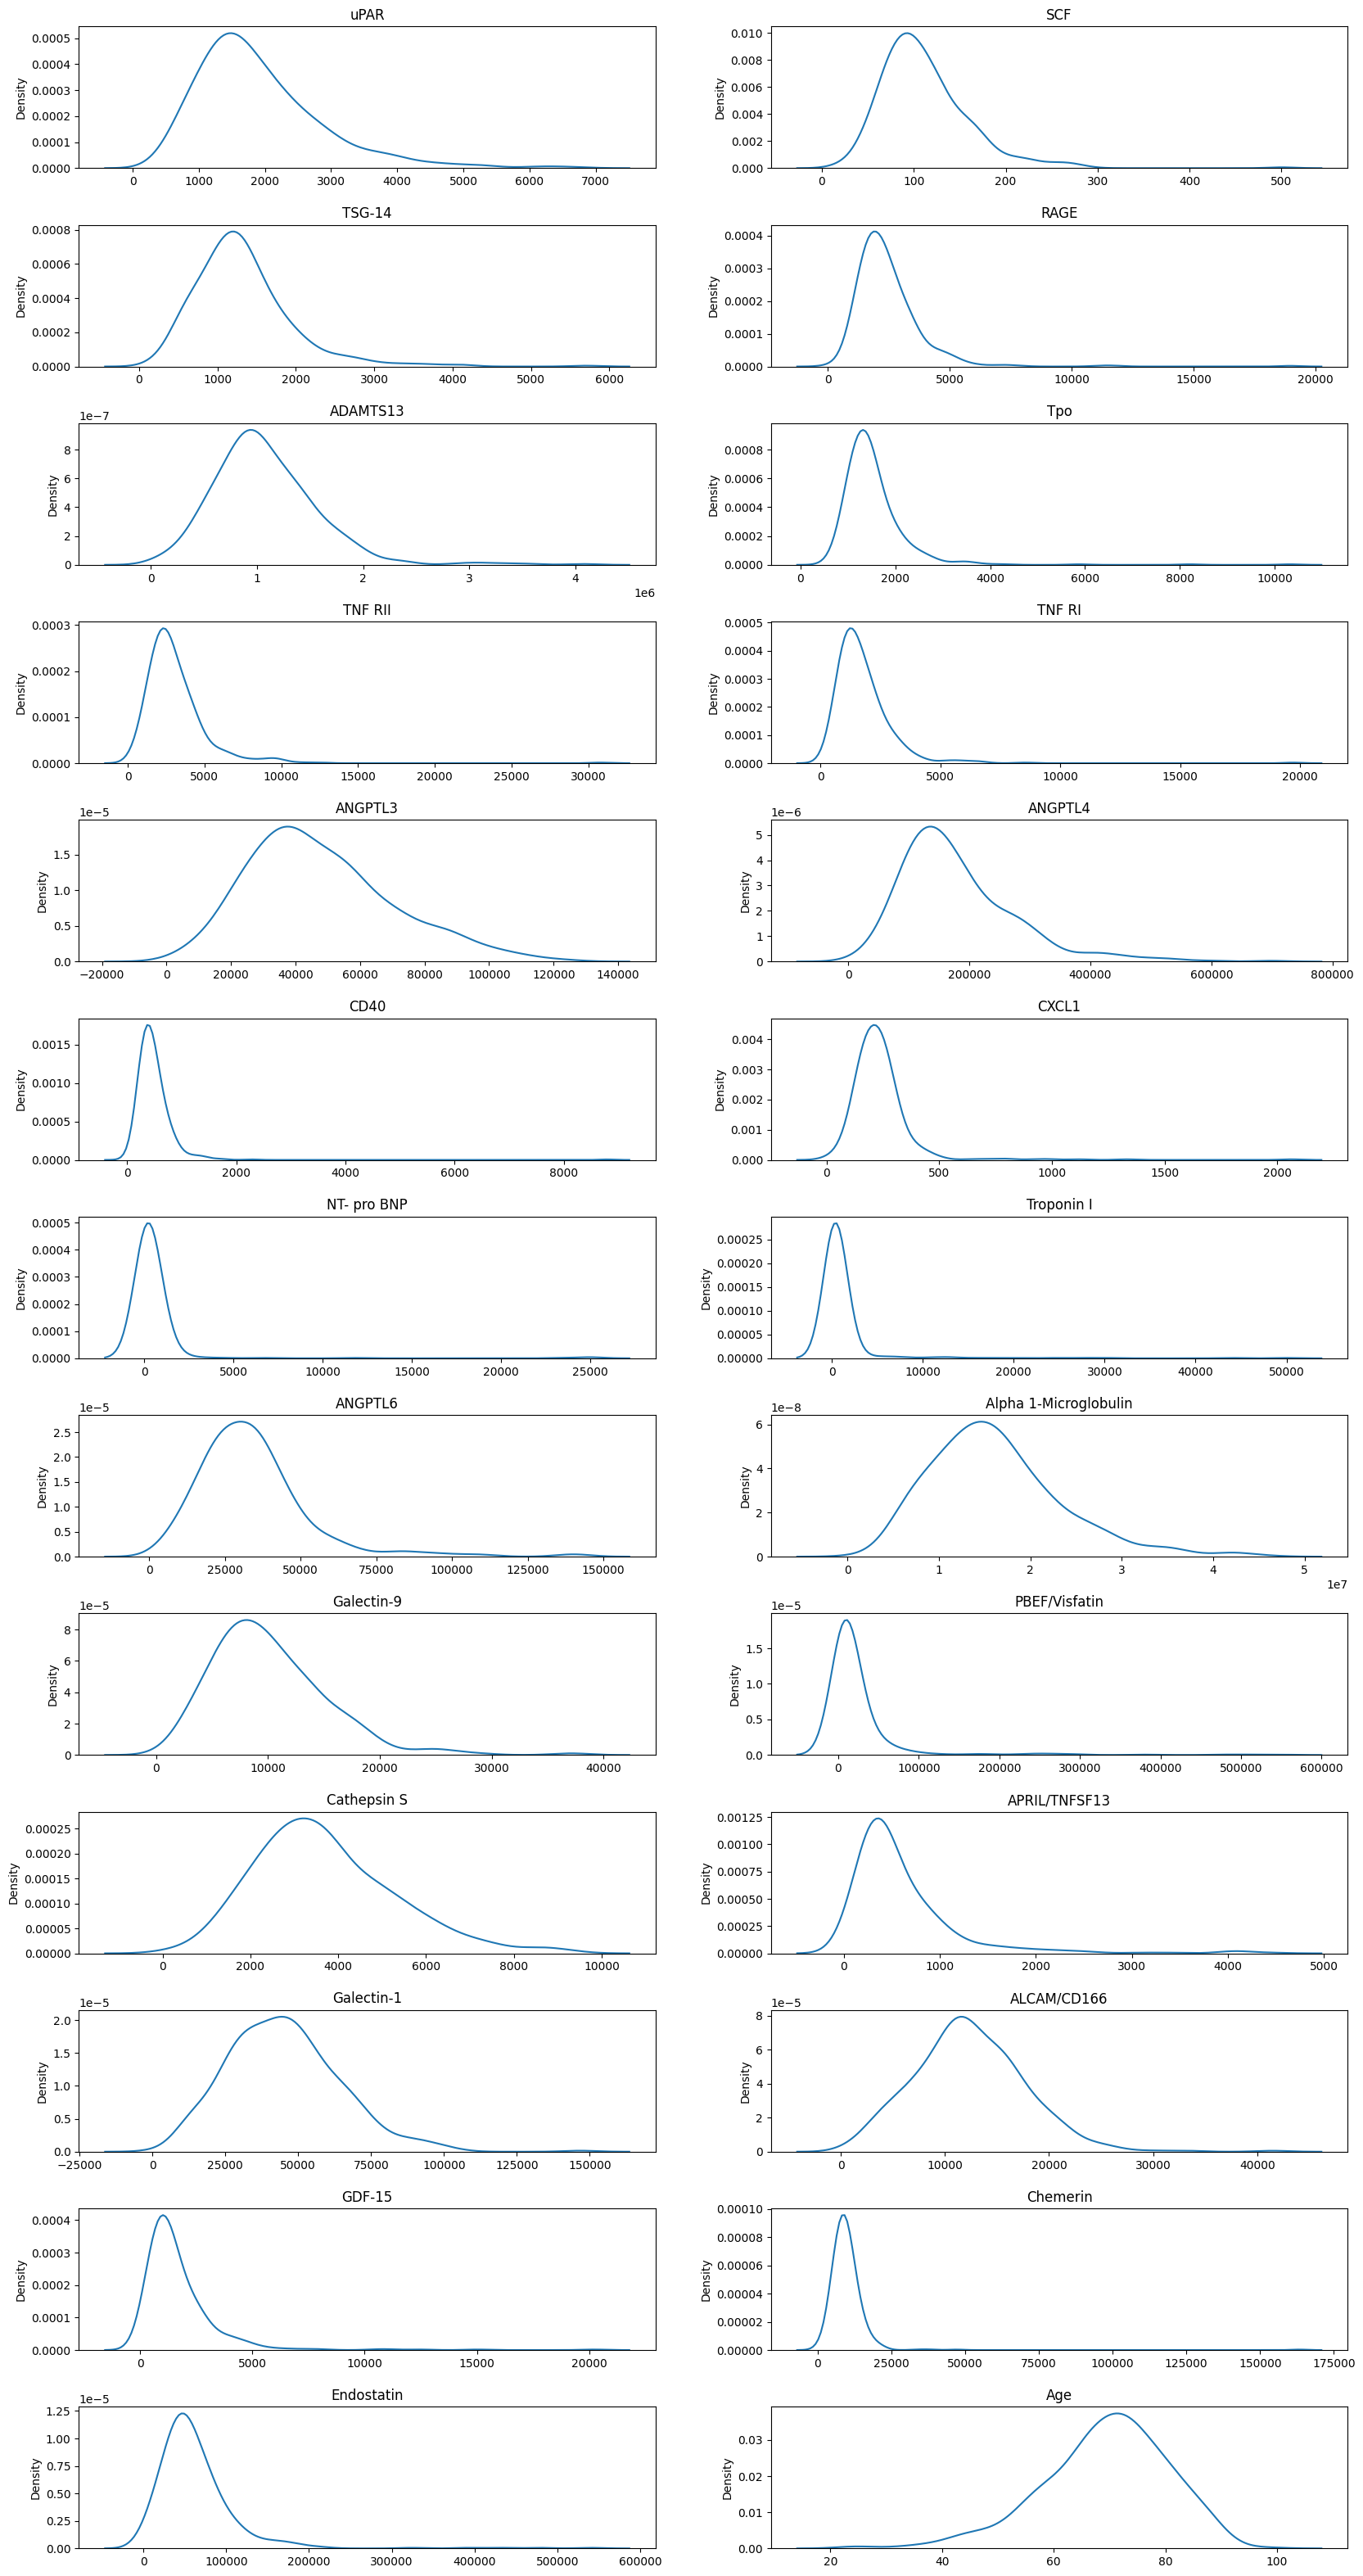

In [60]:
n = len(num_feat_selected)
fig, axs = plt.subplots(nrows = n//2, ncols = 2, figsize = (20,40))
plt.subplots_adjust(hspace=.4) #space between subplots

for col, ax in zip(num_feat_selected, axs.ravel()):
    g = sns.kdeplot(df[col], ax= ax)
    g.set_title(str(col))
    g.set_xlabel("")
plt.show()

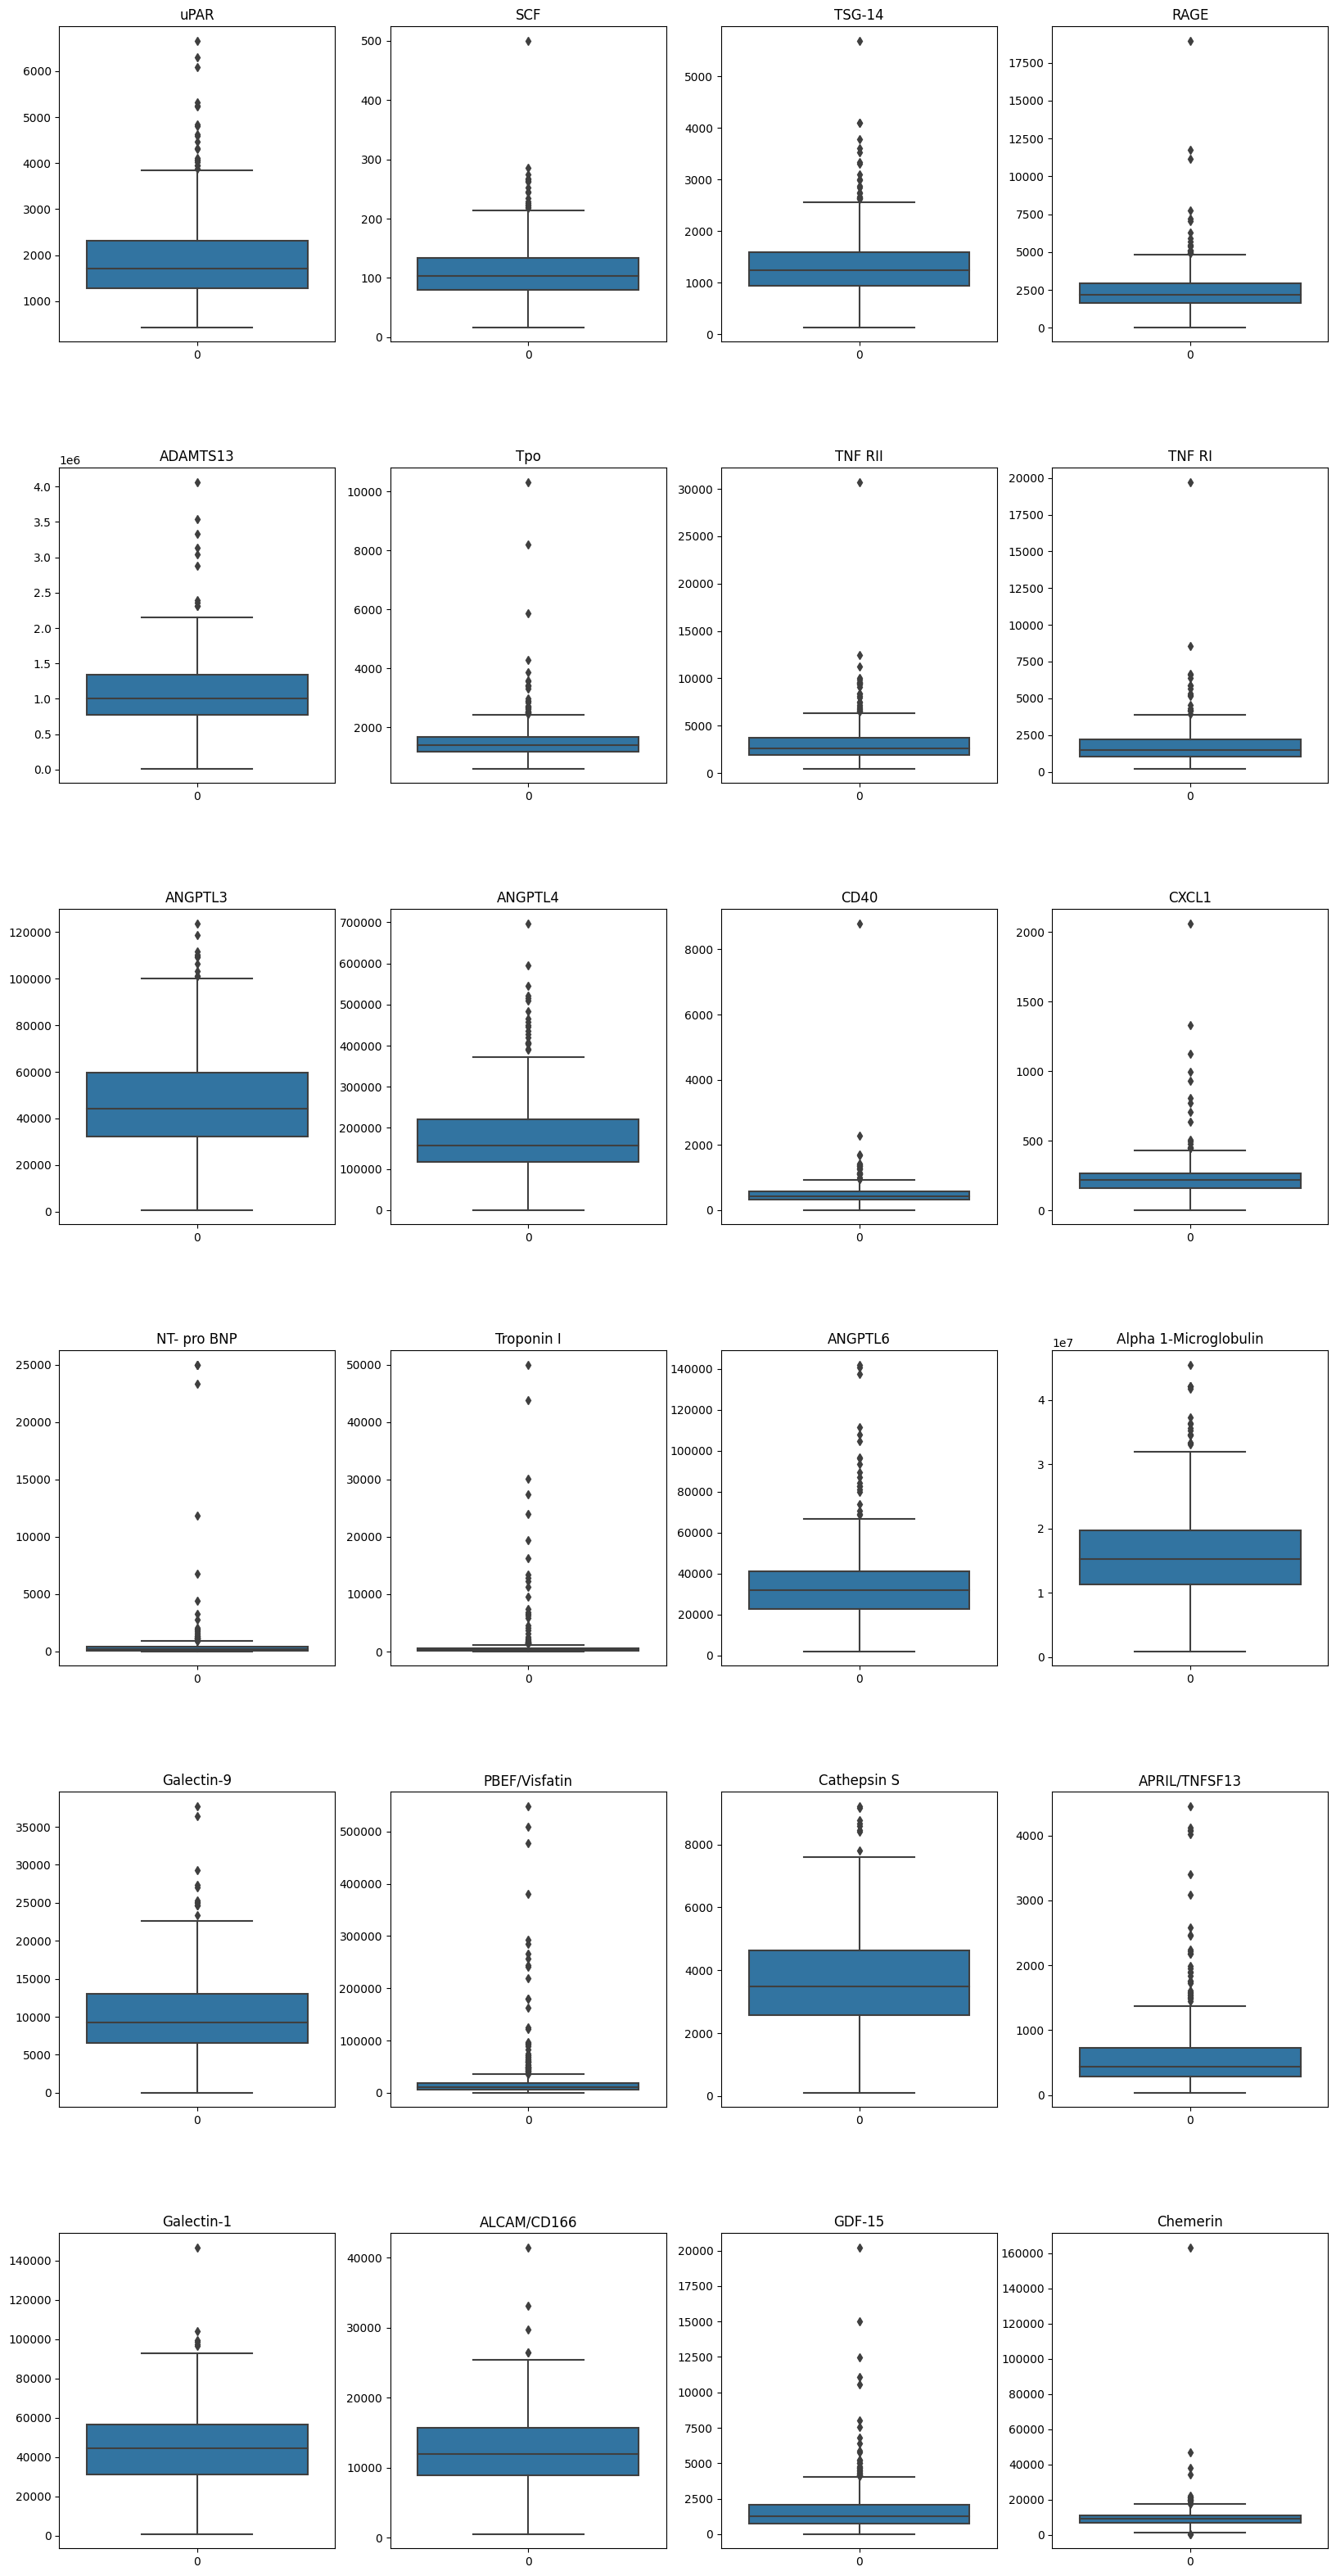

In [61]:
##outlier analysis

n = len(num_feat_selected)
fig, axs = plt.subplots(nrows = n//4, ncols = 4, figsize = (20,40))
plt.subplots_adjust(hspace=.4) #space between subplots

for col, ax in zip(num_feat_selected, axs.ravel()):
    g = sns.boxplot(df[col], ax= ax)
    g.set_title(str(col))
    g.set_xlabel("")
plt.show()

## Comment about FABP3

The data shows no major difference between patient groups regarding this protein.

In [62]:
df[["FABP3 1value (pg/ml) baseline", "FABP4"]]
TableOne(df, columns=["FABP3 1value (pg/ml) baseline", "FABP4"], groupby="hasPAD",  pval = True, smd=True,
                  htest_name=True)

Grouped by hasPAD                                                                                              
                                                    Missing            Overall                  0                  1 P-Value               Test SMD (0,1)
n                                                                          461                166                295                                     
FABP3 1value (pg/ml) baseline, mean (SD)                 36    3962.5 (2142.5)    4149.2 (1926.1)    3849.7 (2259.3)   0.147  Two Sample T-test    -0.143
FABP4, mean (SD)                                         59  23640.7 (35467.4)  26187.4 (25540.6)  22309.4 (39661.2)   0.236  Two Sample T-test    -0.116

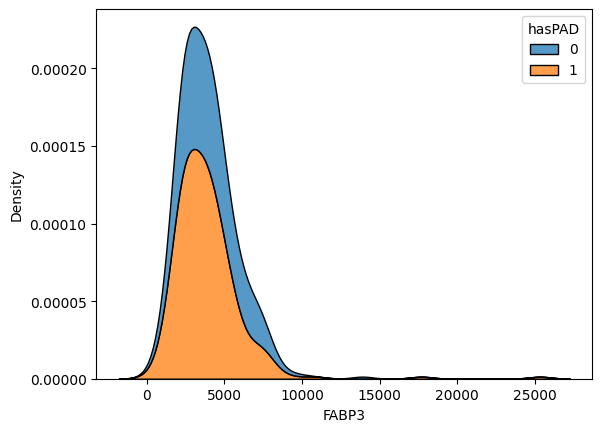

In [63]:
g = sns.kdeplot(df, x = "FABP3 1value (pg/ml) baseline", hue = "hasPAD", multiple="stack")
g.set_xlabel("FABP3")
plt.show()

## Clinical Variables - descriptions


In [65]:
CLINICAL = ['Age', 'Gender', 'Hypertension', 'Hyperchol',
       'Diabetes', 'Renal Insufficiency', 'Smoking Hx',
       #  'Dialysis', # Zero variance
       'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA',
       'statin', 'ACEi/ARB', 'B-bl', 'CCB', 'HCTZ, Lasix', 'Insulin',
       # 'oral hypoglyc' # correlated with Diabetes
       ]

table_args = {
       'categorical': CLINICAL[1:],
       'groupby': ["hasPAD"],
       'pval': True,
       'htest_name': True
}

table_c = TableOne(df, CLINICAL, **table_args)

In [66]:
table_c

Grouped by hasPAD                                                                 
                                              Missing      Overall            0           1 P-Value               Test
n                                                              461          166         295                           
Age, mean (SD)                                      2  69.3 (11.3)  65.6 (12.8)  71.4 (9.8)  <0.001  Two Sample T-test
Gender, n (%)                   0.0                 2   158 (34.4)    62 (37.6)   96 (32.7)   0.336        Chi-squared
                                1.0                     301 (65.6)   103 (62.4)  198 (67.3)                           
Hypertension, n (%)             0.0                 3   108 (23.6)    68 (41.2)   40 (13.7)  <0.001        Chi-squared
                                1.0                     350 (76.4)    97 (58.8)  253 (86.3)                           
Hyperchol, n (%)                0.0                 3   104 (22.7)    57 (34.5)   47 (16.0)  <0.001        Chi-squared
                                1.0                     354 (77.3)   108 (65.5)  246 (84.0)                           
Diabetes, n (%)                 0.0                 1   291 (63.3)   131 (79.4)  160 (54.2)  <0.001        Chi-squared
                                1.0                     169 (36.7)    34 (20.6)  135 (45.8)                           
Renal Insufficiency, n (%)      0.0                 2   447 (97.4)   163 (99.4)  284 (96.3)   0.064     Fisher's exact
                                1.0                       12 (2.6)      1 (0.6)    11 (3.7)                           
Smoking Hx, n (%)               0.0                 5   124 (27.2)    68 (41.7)   56 (19.1)  <0.001        Chi-squared
                                1.0                     237 (52.0)    65 (39.9)  172 (58.7)                           
                                2.0                      95 (20.8)    30 (18.4)   65 (22.2)                           
Congestive heart failure, n (%) 0.0                 6   434 (95.4)   161 (98.8)  273 (93.5)   0.019        Chi-squared
                                1.0                       21 (4.6)      2 (1.2)    19 (6.5)                           
Cornary artery disease, n (%)   0.0                 7   285 (62.8)   120 (74.5)  165 (56.3)  <0.001        Chi-squared
                                1.0                     169 (37.2)    41 (25.5)  128 (43.7)                           
Stroke/TIA, n (%)               0.0                18   365 (82.4)   143 (89.4)  222 (78.4)   0.006        Chi-squared
                                1.0                      78 (17.6)    17 (10.6)   61 (21.6)                           
statin, n (%)                   0.0                27    89 (20.5)    55 (34.8)   34 (12.3)  <0.001        Chi-squared
                                1.0                     345 (79.5)   103 (65.2)  242 (87.7)                           
ACEi/ARB, n (%)                 0.0                28   176 (40.6)    87 (55.1)   89 (32.4)  <0.001        Chi-squared
                                1.0                     257 (59.4)    71 (44.9)  186 (67.6)                           
B-bl, n (%)                     0.0                29   274 (63.4)   111 (70.3)  163 (59.5)   0.033        Chi-squared
                                1.0                     158 (36.6)    47 (29.7)  111 (40.5)                           
CCB, n (%)                      0.0                28   325 (75.1)   131 (82.9)  194 (70.5)   0.006        Chi-squared
                                1.0                     108 (24.9)    27 (17.1)   81 (29.5)                           
HCTZ, Lasix, n (%)              0.0                29   375 (86.8)   141 (89.2)  234 (85.4)   0.323        Chi-squared
                                1.0                      57 (13.2)    17 (10.8)   40 (14.6)                           
Insulin, n (%)                  0.0                30   388 (90.0)   146 (93.0)  242 (88.3)   0.164        Ch

In [68]:
fn3 = 'tableone.html'
table_c.to_html(fn3)